Choose the dataset to use (1 for MNIST, 2 for Fashion MNIST, 3 for CIFAR-10, 4 for Custom CSV Data): 1
Enter the number of training epochs: 5
Loading MNIST dataset...
Epoch 1/5, Loss: 2.3111, Accuracy: 0.4387
Epoch 2/5, Loss: 2.2212, Accuracy: 0.6026
Epoch 3/5, Loss: 2.1365, Accuracy: 0.6610
Epoch 4/5, Loss: 2.0501, Accuracy: 0.6883
Epoch 5/5, Loss: 1.9590, Accuracy: 0.7105


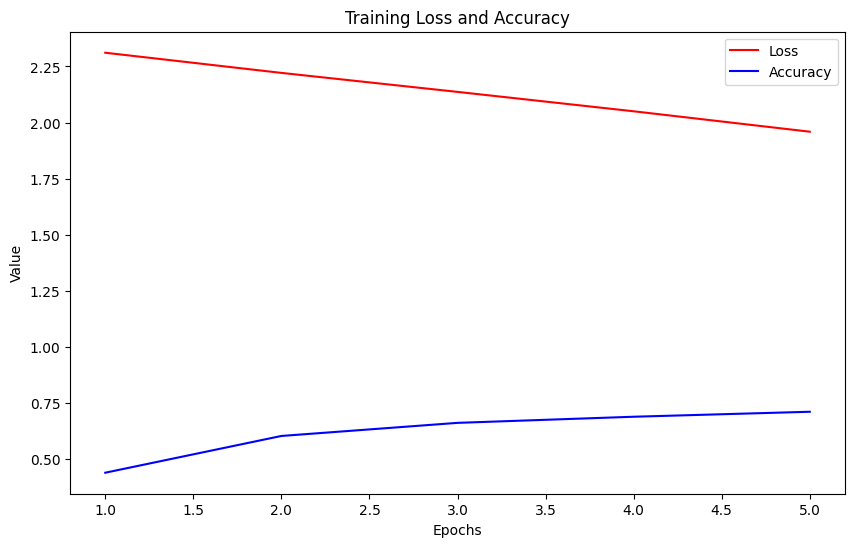

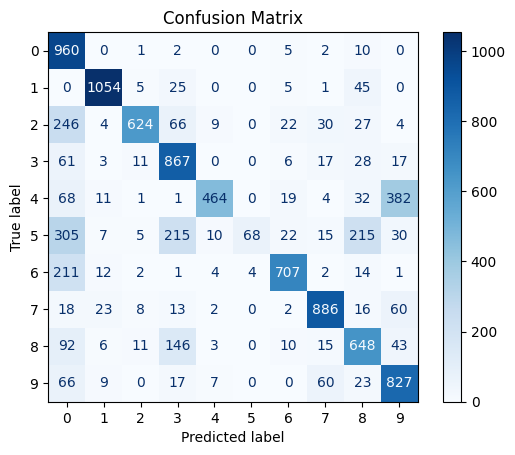


Classification Report:

              precision    recall  f1-score   support

           0     0.4736    0.9796    0.6385       980
           1     0.9336    0.9286    0.9311      1135
           2     0.9341    0.6047    0.7341      1032
           3     0.6408    0.8584    0.7338      1010
           4     0.9299    0.4725    0.6266       982
           5     0.9444    0.0762    0.1411       892
           6     0.8860    0.7380    0.8052       958
           7     0.8585    0.8619    0.8602      1028
           8     0.6125    0.6653    0.6378       974
           9     0.6063    0.8196    0.6970      1009

    accuracy                         0.7105     10000
   macro avg     0.7820    0.7005    0.6805     10000
weighted avg     0.7830    0.7105    0.6903     10000


Specificity (per class):
Class 0: 0.8817
Class 1: 0.9915
Class 2: 0.9951
Class 3: 0.9459
Class 4: 0.9961
Class 5: 0.9996
Class 6: 0.9899
Class 7: 0.9837
Class 8: 0.9546
Class 9: 0.9403


In [2]:
# Install necessary libraries
!pip install torch torchvision scikit-learn matplotlib pandas

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


# Function to apply the sigmoid function element-wise to normalize dataset values
def squash(value):
    value = np.clip(value, -500, 500)  # Clip extreme values
    return 1.0 / (1.0 + np.exp(-value))

# Normalizes a dataset using the squash function
def normalize_dataset(dataset):
    return squash(dataset)

# Load MNIST dataset
def load_mnist():
    print("Loading MNIST dataset...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    x_train = train_dataset.data.numpy() / 255.0
    y_train = train_dataset.targets.numpy()
    x_test = test_dataset.data.numpy() / 255.0
    y_test = test_dataset.targets.numpy()

    return x_train, y_train, x_test, y_test

# Load Fashion MNIST dataset
def load_fashion_mnist():
    print("Loading Fashion MNIST dataset...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

    x_train = train_dataset.data.numpy() / 255.0
    y_train = train_dataset.targets.numpy()
    x_test = test_dataset.data.numpy() / 255.0
    y_test = test_dataset.targets.numpy()

    return x_train, y_train, x_test, y_test

# Load CIFAR-10 dataset
def load_cifar10():
    print("Loading CIFAR-10 dataset...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    x_train = train_dataset.data / 255.0
    y_train = np.array(train_dataset.targets)
    x_test = test_dataset.data / 255.0
    y_test = np.array(test_dataset.targets)

    return x_train, y_train, x_test, y_test

# Load custom dataset from CSV
def load_data(file_path):
    print(f"Loading data from {file_path}...")
    data = pd.read_csv(file_path)

    # Drop unnecessary columns
    if 'id' in data.columns:
        data = data.drop(columns=['id'])
    if 'Unnamed: 32' in data.columns:
        data = data.drop(columns=['Unnamed: 32'])

    # Convert labels to numeric if necessary
    if 'diagnosis' in data.columns:
        data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

    # Separate features and labels
    x_data = data.iloc[:, 1:].values  # Features
    y_data = data.iloc[:, 0].values  # Labels

    return x_data / 255.0, y_data

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def plot_metrics(losses, accuracies):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses, label="Loss", color="red")
    plt.plot(epochs, accuracies, label="Accuracy", color="blue")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.savefig("training_metrics.png")
    plt.show()


# Evaluate model and display confusion matrix and additional metrics
def evaluate_model(model, x_test, y_test, device):
    model.eval()
    with torch.no_grad():
        # Perform predictions
        test_outputs = model(x_test)
        predictions = torch.argmax(test_outputs, dim=1)

    # Convert predictions and true labels to NumPy arrays
    y_true = y_test.cpu().numpy()
    y_pred = predictions.cpu().numpy()

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(len(np.unique(y_true))))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate and display classification report
    report = classification_report(y_true, y_pred, digits=4)
    print("\nClassification Report:\n")
    print(report)

    # Calculate specificity for each class
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])  # True negatives
        fp = cm[:, i].sum() - cm[i, i]  # False positives
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)

    # Print specificity for each class
    print("\nSpecificity (per class):")
    for i, spec in enumerate(specificity):
        print(f"Class {i}: {spec:.4f}")


# Main function
def main():
    dataset_choice = int(input(
        "Choose the dataset to use (1 for MNIST, 2 for Fashion MNIST, 3 for CIFAR-10, 4 for Custom CSV Data): ").strip())
    epochs = int(input("Enter the number of training epochs: ").strip())

    # Load dataset
    if dataset_choice == 1:
        x_train, y_train, x_test, y_test = load_mnist()
        input_dim, output_dim = 28 * 28, 10
    elif dataset_choice == 2:
        x_train, y_train, x_test, y_test = load_fashion_mnist()
        input_dim, output_dim = 28 * 28, 10
    elif dataset_choice == 3:
        x_train, y_train, x_test, y_test = load_cifar10()
        input_dim, output_dim = 32 * 32 * 3, 10
    elif dataset_choice == 4:
        file_path = input("Enter the path to the CSV file: ").strip()
        x_data, y_data = load_data(file_path)
        train_size = int(0.8 * len(x_data))
        x_train, y_train = x_data[:train_size], y_data[:train_size]
        x_test, y_test = x_data[train_size:], y_data[train_size:]
        input_dim, output_dim = x_data.shape[1], len(np.unique(y_data))
    else:
        print("Invalid choice! Defaulting to MNIST.")
        x_train, y_train, x_test, y_test = load_mnist()
        input_dim, output_dim = 28 * 28, 10

    # Initialize the model, optimizer, and loss function
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NeuralNet(input_dim, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    x_train = torch.tensor(x_train.reshape(-1, input_dim), dtype=torch.float32).to(device)
    x_test = torch.tensor(x_test.reshape(-1, input_dim), dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    # Training loop
    losses, accuracies = [], []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(x_test)
            predictions = torch.argmax(test_outputs, dim=1)
            accuracy = (predictions == y_test).float().mean().item()
            accuracies.append(accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

    plot_metrics(losses, accuracies)
    evaluate_model(model, x_test, y_test, device)

if __name__ == "__main__":
    main()
